In [1]:
%load_ext autoreload
%autoreload 2

In [166]:
import numpy as np
import scipy.stats as st
import scipy.integrate as si
import scipy.signal as ss
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from simulate_triple import simulate
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from tools_plot import despine, set_style
import pandas as pd
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

from causal_optoconnectics.core import (
    causal_connectivity_kde, probable_connectivity_kde, 
    causal_connectivity_mean, probable_connectivity_mean, find_response_spikes
)

%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

## Simulate the triple setup
Neurons A,B,C have statistical dependency as given by the graph below

Stimulation S is randomly assigned, but identical for A and B

We want to determine the causal connectivity between A and C, and B and C.

In [4]:
colors = ['#1b9e77', '#d95f02', '#7570b3']

In [8]:
# J_ACs = np.arange(0, 7.1, .1)
# simulations_J_AC = defaultdict(list)
# for a in tqdm(J_ACs):
#     data = simulate(stop_time=4000, J_AC=a, ac_amp=1., ac_offset=-.5, pbar=lambda x:x)
#     stop_time = data['status']['time']
#     spiketrains = data['spiketrains'].groupby('senders')
#     A_spikes = spiketrains.get_group(1)['times'].to_numpy()
#     B_spikes = spiketrains.get_group(2)['times'].to_numpy()
#     C_spikes = spiketrains.get_group(3)['times'].to_numpy()
    
#     simulations_J_AC['stim_times'].append(data['stim_times'])
#     simulations_J_AC['A_spikes'].append(A_spikes)
#     simulations_J_AC['B_spikes'].append(B_spikes)
#     simulations_J_AC['C_spikes'].append(C_spikes)
#     simulations_J_AC['stop_time'].append(stop_time)
#     simulations_J_AC['J_AC'].append(a)

# np.savez('simulations_J_AC_osc.npz', data=simulations_J_AC)
simulations = np.load('simulations_J_AC_osc.npz', allow_pickle=True)['data'][()]

In [167]:
simulations = simulations
amps = simulations['J_AC']

# simulations = simulations_stim_amp
# amps = simulations_stim_amp['stim_amps']


x1 = 1
x2 = 3
y1 = 3
y2 = 5
dt = 20
dz = 2

spikes = defaultdict(list)
for i, a in enumerate(tqdm(amps)):

    S_times = simulations['stim_times'][i]
    A_spikes = simulations['A_spikes'][i]
    B_spikes = simulations['B_spikes'][i]
    C_spikes = simulations['C_spikes'][i]
    stop_time = simulations['stop_time'][i]
    
    Z_A, X_A, Y_A = find_response_spikes(
        A_spikes, C_spikes, S_times, dt=dt, dz=dz)
    Z_B, X_B, Y_B = find_response_spikes(
        B_spikes, C_spikes, S_times, dt=dt, dz=dz)
    
    X_A = np.array([any((t >= x1) & (t <= x2)) for t in X_A])
    Y = np.array([any((t >= y1) & (t <= y2)) for t in Y_A])
    
    d = y2 - y1
    Y_0 = np.array([any((t >= dt - d) & (t <= dt)) for t in Y_A])
    
    X_B = np.array([any((t >= x1) & (t <= x2)) for t in X_B])
    
    spikes['Z_A'].append(Z_A)
    spikes['X_A'].append(X_A)
    spikes['Y_A_X1'].append(Y[X_A==1])
    spikes['Y_A_X0'].append(Y[X_A==0])
    spikes['Y_A_Z1'].append(Y[Z_A==1]) # unbiased estimate of background
    
    spikes['Y_A0_X1'].append(Y_0[X_A==1])
    spikes['Y_A0_X0'].append(Y_0[X_A==0])
    spikes['Y_A0_Z1'].append(Y_0[Z_A==1])
    
    spikes['Z_B'].append(Z_B)
    spikes['X_B'].append(X_B)
    spikes['Y_B_X1'].append(Y[X_B==1])
    spikes['Y_B_X0'].append(Y[X_B==0])
    spikes['Y_B_Z1'].append(Y[Z_B==1])
    
    spikes['Y_B0_X1'].append(Y_0[X_B==1])
    spikes['Y_B0_X0'].append(Y_0[X_B==0])
    spikes['Y_B0_Z1'].append(Y_0[Z_B==1])

pynest:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [182]:
results = defaultdict(list)
for i, a in enumerate(tqdm(amps)):

    Z_A = spikes['Z_A'][i]
    X_A = spikes['X_A'][i]
    Y_A_X0 = spikes['Y_A_X0'][i]
    Y_A_X1 = spikes['Y_A_X1'][i]
    Y_A_Z1 = spikes['Y_A_Z1'][i]
    
    Y_A0_X0 = spikes['Y_A0_X0'][i]
    Y_A0_X1 = spikes['Y_A0_X1'][i]
    Y_A0_Z1 = spikes['Y_A0_Z1'][i]
    
    Z_B = spikes['Z_A'][i]
    X_B = spikes['X_A'][i]
    Y_B_X0 = spikes['Y_B_X0'][i]
    Y_B_X1 = spikes['Y_B_X1'][i]
    Y_B_Z1 = spikes['Y_B_Z1'][i]
    
    Y_B0_X0 = spikes['Y_B0_X0'][i]
    Y_B0_X1 = spikes['Y_B0_X1'][i]
    Y_B0_Z1 = spikes['Y_B0_Z1'][i]
#     beta_AC = Y_A_X1.mean() - Y_A_Z1.mean()
#     beta_BC = Y_B_X1.mean() - Y_B_Z1.mean()
    beta_AC = Y_A_X1.mean() - Y_A_Z1.mean() + Y_A0_Z1.mean()
    beta_BC = Y_B_X1.mean() - Y_B_Z1.mean() + Y_B0_Z1.mean() 
#     beta_AC = Y_A_X1.mean() - Y_A_Z1.mean() - Y_A0_X1.mean() + Y_A0_Z1.mean()
#     beta_BC = Y_B_X1.mean() - Y_B_Z1.mean() - Y_B0_X1.mean()  + Y_B0_Z1.mean() 
#     Y_A_X1 = np.random.choice(Y_A_X1, len(Y_A_Z1))
#     Y_B_X1 = np.random.choice(Y_B_X1, len(Y_B_Z1))
#     beta_AC = Y_A_X1.mean() - Y_A_Z1.mean()
#     beta_BC = Y_B_X1.mean() - Y_B_Z1.mean()
    
    results['beta_AC'].append(beta_AC)
    results['beta_BC'].append(beta_BC)
    
    cond_AC = Y_A_X1.mean() - Y_A_X0.mean()# - Y_A0_X1.mean() + Y_A0_X0.mean()
    cond_BC = Y_B_X1.mean() - Y_B_X0.mean()# - Y_B0_X1.mean() + Y_B0_X0.mean()
    
    results['cond_AC'].append(cond_AC)
    results['cond_BC'].append(cond_BC)
results = pd.DataFrame(results)

pynest:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Text(0.5, 1.0, 'BC')

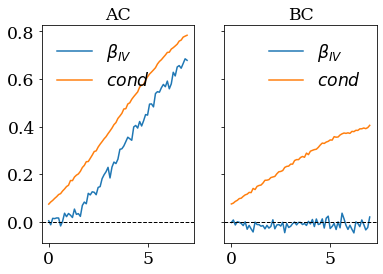

In [183]:
fig, axs = plt.subplots(1, 2, sharey=True)
axba, axbb = axs.flatten()

a= 0.0
axba.plot(amps, results['beta_AC'] + a, label=r'$\beta_{IV}$')
# axba.plot(amps, (results['rate_C'] - results['rate_C'][0]) / (results['rate_A'] + results['rate_S']))

axbb.plot(amps, results['beta_BC'] + a, label=r'$\beta_{IV}$')

axba.plot(amps, results['cond_AC'], label=r'$cond$')
axbb.plot(amps, results['cond_BC'], label=r'$cond$')

axba.axhline(0, color='k', lw=1, ls='--')
axbb.axhline(0, color='k', lw=1, ls='--')
axba.legend(frameon=False, loc=0)
axbb.legend(frameon=False, loc=0)
# axbb.set_xlabel('Connection strength AC')
axba.set_title('AC')
axbb.set_title('BC')


In [9]:
i = 10

S = simulations['stim_times'][i]
A = simulations['A_spikes'][i]
B = simulations['B_spikes'][i]
C = simulations['C_spikes'][i]
stop_time = simulations['stop_time'][i]
print(simulations['J_AC'][i])

1.0


In [18]:
Z_A, X_A, Y_A = find_response_spikes(A, C, S, dt=30, dz=1)
Z_B, X_B, Y_B = find_response_spikes(B, C, S, dt=30, dz=1)

(0, 30)

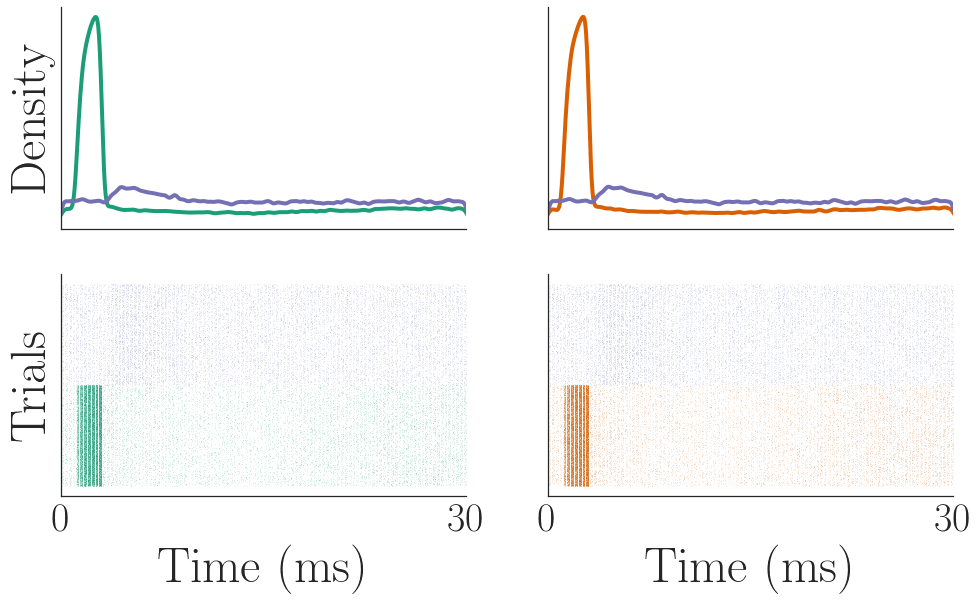

In [120]:
set_style(h=2, style='notebook')
fig, axs = plt.subplots(2, 2, sharex=True)

sigma = .02
s = 0.01

spike_trials = [t for trial in X_A for t in trial]
spike_ids = [t for i, trial in enumerate(X_A) for t in [i]*len(trial)]

pd.Series(spike_trials).plot.kde(ax=axs[0,0], bw_method=sigma, color=colors[0])
axs[1,0].scatter(spike_trials, spike_ids, s=s, color=colors[0])

spike_trials = [t for trial in Y_A for t in trial]
spike_ids = [t for i, trial in enumerate(Y_A) for t in [i+len(X_A)]*len(trial)]

pd.Series(spike_trials).plot.kde(ax=axs[0,0], bw_method=sigma, color=colors[2])
axs[1,0].scatter(spike_trials, spike_ids, s=s, color=colors[2])
# B 


spike_trials = [t for trial in X_B for t in trial]
spike_ids = [t for i, trial in enumerate(X_B) for t in [i]*len(trial)]

pd.Series(spike_trials).plot.kde(ax=axs[0,1], bw_method=sigma, color=colors[1])
axs[1,1].scatter(spike_trials, spike_ids, s=s, color=colors[1])

spike_trials = [t for trial in Y_B for t in trial]
spike_ids = [t for i, trial in enumerate(Y_B) for t in [i+len(X_A)]*len(trial)]

pd.Series(spike_trials).plot.kde(ax=axs[0,1], bw_method=sigma, color=colors[2])
axs[1,1].scatter(spike_trials, spike_ids, s=s, color=colors[2])


axs[0,0].set_xticks([0,30])
axs[1,0].set_xlabel('Time (ms)')
axs[1,1].set_xlabel('Time (ms)')
axs[0,1].set_ylabel('')
axs[1,0].set_ylabel('Trials')
despine(yticks=False)
plt.xlim(0,30)
# fig.savefig('../manuscript/triple-response.png', dpi=300)

In [125]:
sum(Z_A), sum(Z_B)

(551, 538)

(0, 30)

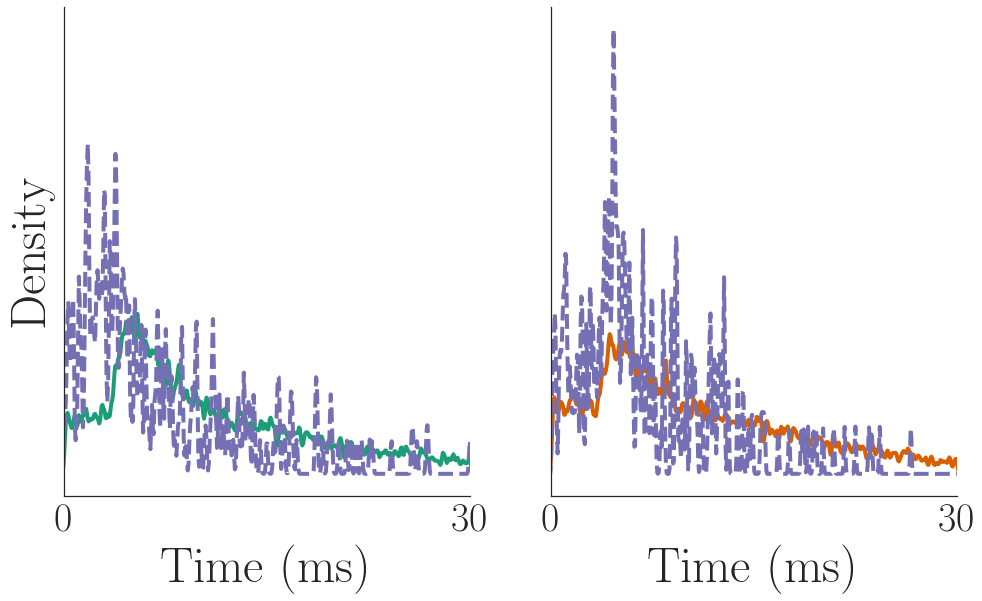

In [127]:
set_style(h=2, style='notebook')
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

sigma = .01

X_AA = np.array([any((t >= iv_params['x1']) & (t <= iv_params['x2'])) for t in X_A])

spike_trials = [t for trial in Y_A[X_AA==1] for t in trial]

pd.Series(spike_trials).plot.kde(ax=axs[0], bw_method=sigma, color=colors[0])

spike_trials = [t for trial in Y_A[Z_A==1] for t in trial]

pd.Series(spike_trials).plot.kde(ax=axs[0], bw_method=sigma, color=colors[2], ls='--')
# B 

X_BB = np.array([any((t >= iv_params['x1']) & (t <= iv_params['x2'])) for t in X_B])

spike_trials = [t for trial in Y_B[X_BB==1] for t in trial]

pd.Series(spike_trials).plot.kde(ax=axs[1], bw_method=sigma, color=colors[1])

spike_trials = [t for trial in Y_B[Z_B==1] for t in trial]

pd.Series(spike_trials).plot.kde(ax=axs[1], bw_method=sigma, color=colors[2], ls='--')


axs[0].set_xticks([0,30])
axs[0].set_xlabel('Time (ms)')
axs[1].set_xlabel('Time (ms)')
# axs[0,1].set_ylabel('')
# axs[1,0].set_ylabel('Trials')
despine(yticks=False)
plt.xlim(0,30)

# spike time relationship

In [99]:
i = 70

S = simulations['stim_times'][i]
A = simulations['A_spikes'][i]
B = simulations['B_spikes'][i]
C = simulations['C_spikes'][i]
stop_time = simulations['stop_time'][i]
print(simulations['J_AC'][i])

7.0


In [164]:
def find_response_spikes_(x, y, s, dt, dz):
    s = s.astype(float)
    X, Y, Z = [], [], []
    for t in s:
        # searchsorted:
        # left	a[i-1] < v <= a[i]
        # right	a[i-1] <= v < a[i]
        # t - dz < z <= t
        idx_z = np.searchsorted(x, [t - dz, t], side='right')
        Z.append(x[idx_z[0]: idx_z[1]] - t)
        # t < x <= t + dt
        idx_x = np.searchsorted(x, [t, t + dt], side='right')
        X.append(x[idx_x[0]: idx_x[1]] - t)
        # t < y <= t + dt
        idx_y = np.searchsorted(y, [t, t + dt], side='right')
        Y.append(y[idx_y[0]: idx_y[1]] - t)
    Z = np.array(Z)
    X = np.array(X)
    Y = np.array(Y)
    return Z, X, Y

In [165]:
Z_A, X_A, Y_A = find_response_spikes_(A, C, S, dt=15, dz=15)
Z_B, X_B, Y_B = find_response_spikes_(B, C, S, dt=15, dz=15)

In [144]:
zz, xx, sa = [], [], []
for z, x, y in zip(Z_A, X_A, Y_A):
    zz.append(any(z > -2))
    xx.append(any((x < 3) & (x > 1)))
    tt = np.concatenate([z, x])
    sa.append([s for t in tt for s in y - t])
    
zz, xx, sa = np.array(zz), np.array(xx), np.array(sa)

sazz = sa[zz==1]
saxx = sa[xx==1]

saxx = np.random.choice(saxx, len(sazz))

saz = np.array([t for tr in sazz for t in tr])
sax = np.array([t for tr in saxx for t in tr])

In [145]:
zz, xx, sb = [], [], []
for z, x, y in zip(Z_B, X_B, Y_B):
    zz.append(any(z > -2))
    xx.append(any((x < 3) & (x > 1)))
    tt = np.concatenate([z, x])
    sb.append([s for t in tt for s in y - t])
    
zz, xx, sb = np.array(zz), np.array(xx), np.array(sb)

sbzz = sb[zz==1]
sbxx = sb[xx==1]

sbxx = np.random.choice(sbxx, len(sbzz))

sbz = np.array([t for tr in sbzz for t in tr])
sbx = np.array([t for tr in sbxx for t in tr])

In [146]:
len(sbzz), len(sbxx), len(sazz), len(saxx)

(1037, 1037, 1079, 1079)

In [147]:
from scipy.stats import gaussian_kde

In [148]:
from scipy.stats import wasserstein_distance, energy_distance

In [149]:
wasserstein_distance(saz[saz > 0], sax[sax > 0]), energy_distance(saz[saz > 0], sax[sax > 0])

(1.3555894234767825, 0.4630613964719345)

In [150]:
wasserstein_distance(sbz[sbz > 0], sbx[sbx > 0]), energy_distance(sbz[sbz > 0], sbx[sbx > 0])

(2.040421305236249, 1.0589292982590433)

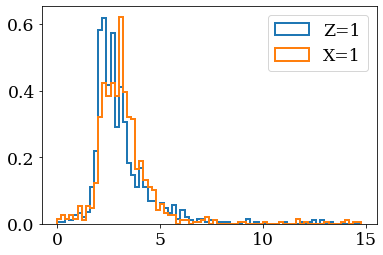

In [115]:
b = np.arange(0, 15, .2)
haz, _, _ = plt.hist(saz, bins=b, histtype='step', lw=2, density=True, label='Z=1')
hax, _, _ = plt.hist(sax, bins=b, histtype='step', lw=2, density=True, label='X=1')
plt.legend()

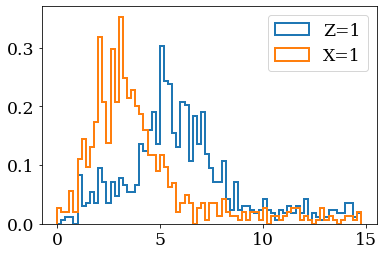

In [116]:
hbz, _, _ = plt.hist(sbz, bins=b, histtype='step', lw=2, density=True, label='Z=1')
hbx, _, _ = plt.hist(sbx, bins=b, histtype='step', lw=2, density=True, label='X=1')
plt.legend()

In [128]:
b = np.arange(0, 15, .01)

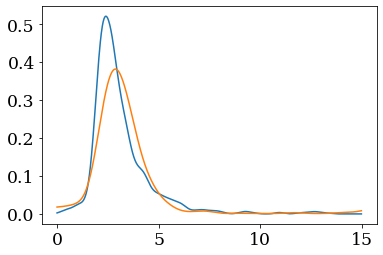

In [135]:
kaz = gaussian_kde(saz, .1)(b)
plt.plot(b, kaz)
kax = gaussian_kde(sax, .1)(b)
plt.plot(b, kax)

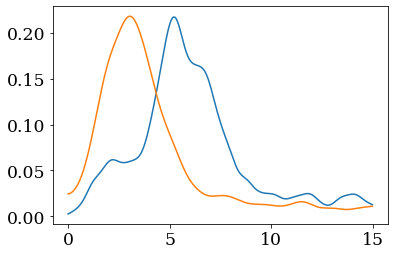

In [136]:
kbz = gaussian_kde(sbz, .1)(b)
plt.plot(b, kbz)
kbx = gaussian_kde(sbx, .1)(b)
plt.plot(b, kbx)

In [153]:
wasserstein_distance(b, b, kaz, kax), energy_distance(b, b, kaz, kax)

(0.2392819391391432, 0.1759117706270374)

In [154]:
wasserstein_distance(b, b, kbz, kbx), energy_distance(b, b, kbz, kbx)

(2.046126673063287, 1.1044604894020884)

In [61]:
# simulations = simulations_J_AC
# amps = simulations_J_AC['J_AC']

# # simulations = simulations_stim_amp
# # amps = simulations_stim_amp['stim_amps']

# from causal_optoconnectics.core import (
#     causal_connectivity, probable_connectivity, 
#     causal_connectivity_mean, probable_connectivity_mean
# )


# iv_params = {
#     'x1': 1,
#     'x2': 3,
#     'y1': 3,
#     'y2': 8,
#     'dt': 20,
#     'dz': 1
# }

# cond_params = {
#     'x1': 1,
#     'x2': 3,
#     'y1': 3,
#     'y2': 8,
#     'dt': 20
# }


# results = defaultdict(list)
# for i, a in enumerate(tqdm(amps)):

#     stim_times = simulations['stim_times'][i]
#     A_spikes = simulations['A_spikes'][i]
#     B_spikes = simulations['B_spikes'][i]
#     C_spikes = simulations['C_spikes'][i]
#     stop_time = simulations['stop_time'][i]
    
# #     beta_AC = causal_connectivity(A_spikes, C_spikes, stim_times, **iv_params)
# #     beta_BC = causal_connectivity(B_spikes, C_spikes, stim_times, **iv_params)
#     beta_AC = causal_connectivity_mean(A_spikes, C_spikes, stim_times, **iv_params)
#     beta_BC = causal_connectivity_mean(B_spikes, C_spikes, stim_times, **iv_params)
    
#     results['beta_AC'].append(beta_AC)
#     results['beta_BC'].append(beta_BC)
    
# #     cond_AC = probable_connectivity(A_spikes, C_spikes, stim_times, **cond_params)
# #     cond_BC = probable_connectivity(B_spikes, C_spikes, stim_times, **cond_params)
#     cond_AC = probable_connectivity_mean(A_spikes, C_spikes, stim_times, **cond_params)
#     cond_BC = probable_connectivity_mean(B_spikes, C_spikes, stim_times, **cond_params)
    
#     results['cond_AC'].append(cond_AC)
#     results['cond_BC'].append(cond_BC)
    
#     results['rate_A'].append(len(A_spikes) / stop_time * 1000)
#     results['rate_B'].append(len(B_spikes) / stop_time * 1000)
#     results['rate_C'].append(len(C_spikes) / stop_time * 1000)
#     results['rate_S'].append(len(stim_times) / stop_time * 1000)
# #     break
    
# results = pd.DataFrame(results)

In [30]:
data = simulate(stop_time=600, record_state=True, ac_amp=1., ac_offset=-.5, pbar=tqdm)

HBox(children=(IntProgress(value=0, max=9508), HTML(value='')))

In [31]:
state = data['state'].groupby('senders')
spiketrains = data['spiketrains'].groupby('senders')

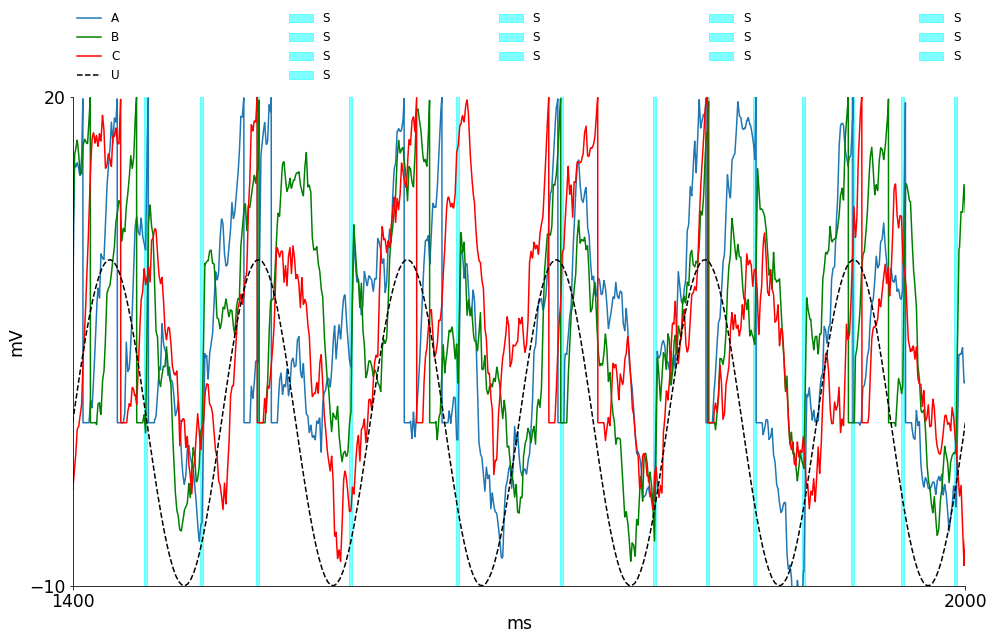

In [32]:
plt.figure(figsize=(16,9))
xlim = [1400, 2000]
ylim = [-10, 20]
mask_s = (data['stim_times'] > xlim[0]) & (data['stim_times'] < xlim[1])
plt.plot(state.get_group(1).times, state.get_group(1).V_m, label='A')
plt.plot(state.get_group(2).times, state.get_group(2).V_m, 'g', label='B')
plt.plot(state.get_group(3).times, state.get_group(3).V_m, 'r', label='C')
for s in data['stim_times'][mask_s]:
    plt.axvspan(s, s+2, alpha=.5, color='cyan', label='S')
    
t = np.linspace(0, xlim[-1], 1000)
ac = 10 * np.sin(2 * np.pi * data['params']['ac_freq'] * t)
plt.plot(t, ac, '--k', label='U')
plt.xlim(xlim)
plt.xlabel('ms')
plt.ylabel('mV')

plt.ylim(ylim)
plt.legend(
    frameon=False,
    bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
    mode="expand", borderaxespad=0, ncol=5, fontsize='large')

plt.gca().set_yticks(ylim)
plt.gca().set_xticks(xlim)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

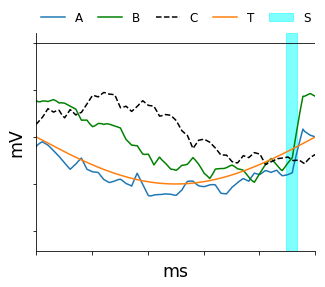

In [33]:
plt.figure(figsize=(5,4))
xlim = [950, 1000]
mask_s = (data['stim_times'] > xlim[0]) & (data['stim_times'] < xlim[1])
plt.plot(state.get_group(1).times, state.get_group(1).V_m, label='A')
plt.plot(state.get_group(2).times, state.get_group(2).V_m, 'g', label='B')
plt.plot(state.get_group(3).times, state.get_group(3).V_m, '--k', label='C')
for s in data['stim_times'][mask_s]:
    plt.axvspan(s, s+2, alpha=.5, color='cyan', label='S')
    
t = np.linspace(0, 1000, 1000)
ac = 10 * np.sin(2 * np.pi * data['params']['ac_freq'] * t)
plt.plot(t, ac, label='T')
plt.xlim(xlim)
plt.xlabel('ms')
plt.ylabel('mV')
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.ylim(-5, 20)
plt.legend(
    frameon=False,
    bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
    mode="expand", borderaxespad=0, ncol=5, fontsize='large')
plt.axhline(20, color='k', lw=.8)